# 꽃 분류 CNN 모델링

## 1. 라이브러리 및 모듈 임포트

In [1]:
import os, shutil
import pickle 
import pathlib
from tensorflow import keras
from keras import layers
from keras import models
from keras.models import load_model 
import matplotlib.pyplot as plt
from keras import optimizers

import numpy as np 
import pandas as pd 
import tensorflow as tf 

## 2. 데이터 준비

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(f"데이터가 다운로드된 경로: {data_dir}")

228813984/228813984 [==============================] - 7s 0us/step
데이터가 다운로드된 경로: C:\Users\Admin\.keras\datasets\flower_photos


## 3. 모델 학습

### 3.1. 하이퍼파라미터 및 데이터 증강 설정

In [3]:
batch_size=32
img_height = 180
img_width  = 180

# 데이터 증강을 위한 파라미터 지정
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

### 3.2. 데이터셋 로드

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("클래스 종류:", class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
클래스 종류: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 3.3. CNN 모델 정의 및 컴파일

In [5]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, img_height, img_width, 3)) # build the model to print summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                               

### 3.4. 모델 학습 및 저장

In [7]:
history = model.fit(train_ds,
                    # epochs=30,
                    epochs=3,
                    validation_data=val_ds)

# 모델과 학습 기록 저장
model.save("flowers_model.keras")
with open("flowers_hist.pkl", "wb") as f:
    pickle.dump(history.history, f)

Epoch 1/3


92/92 [==============================] - 63s 684ms/step - loss: 1.0722 - accuracy: 0.5770 - val_loss: 1.0217 - val_accuracy: 0.6035
Epoch 2/3
92/92 [==============================] - 59s 641ms/step - loss: 0.9085 - accuracy: 0.6482 - val_loss: 0.8918 - val_accuracy: 0.6471
Epoch 3/3
92/92 [==============================] - 59s 639ms/step - loss: 0.8333 - accuracy: 0.6686 - val_loss: 0.8578 - val_accuracy: 0.6635


## 4. 학습 결과 시각화

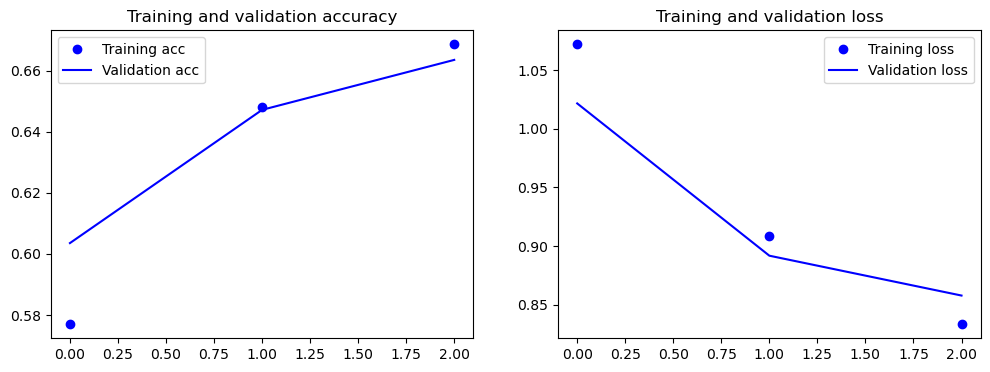

In [8]:
with open("flowers_hist.pkl", "rb") as f:
    history = pickle.load(f)

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 5. 모델 평가 (검증 데이터셋)

In [9]:
model = load_model("flowers_model.keras")

match_cnt = 0
total_cnt = 0

print("검증 데이터셋을 사용하여 평가를 시작합니다...")
for i, (images, labels) in enumerate(val_ds):
    labels = labels.numpy()
    outputs = model.predict(images, verbose=0)
    preds = np.argmax(outputs, axis=1)
    
    match_cnt += np.sum(preds == labels)
    total_cnt += len(labels)
    
    # 첫 번째 배치에 대해서만 샘플 예측 결과 출력
    if i == 0:
        print("\n첫 번째 배치 샘플 예측:")
        for j in range(min(5, len(labels))): # 최대 5개 샘플 출력
            print(f"  - 실제: {class_names[labels[j]]:<12} | 예측: {class_names[preds[j]]:<12} | 결과: {'정답' if labels[j] == preds[j] else '오답'}")

print("\n--- 최종 평가 결과 ---")
print(f"정확도: {match_cnt / total_cnt * 100:.2f}%")
print(f"전체 이미지 수: {total_cnt}")
print(f"정답 개수: {match_cnt}")
print(f"오답 개수: {total_cnt - match_cnt}")

검증 데이터셋을 사용하여 평가를 시작합니다...

첫 번째 배치 샘플 예측:
  - 실제: roses        | 예측: tulips       | 결과: 오답
  - 실제: roses        | 예측: tulips       | 결과: 오답
  - 실제: tulips       | 예측: tulips       | 결과: 정답
  - 실제: roses        | 예측: roses        | 결과: 정답
  - 실제: daisy        | 예측: sunflowers   | 결과: 오답

--- 최종 평가 결과 ---
정확도: 66.35%
전체 이미지 수: 734
정답 개수: 487
오답 개수: 247
